# Lab Report: Reinforcement Learning Fundamentals
**Course:** REL301m  
**Topic:** Discount Factors and Q-Learning Performance  

## Introduction
This report explores three fundamental concepts in Reinforcement Learning:
1. **The Impact of Discount Factors ($\gamma$):** Analyzing how the horizon of optimization affects cumulative returns in a controlled temperature regulation environment.
2. **Q-Learning Implementation:** Evaluating the training performance and learning curve of a Q-learning agent on the `CartPole-v1` environment using state discretization.
3. **Q-Learning with Real-World Data:** Applying Q-learning to a Bitcoin trading environment using historical price data from Kaggle.

## Theoretical Background

### 1. Discount Factor ($\gamma$)
The discount factor $\gamma \in [0, 1]$ determines the present value of future rewards. 
- A low $\gamma$ (close to 0) makes the agent "myopic," focusing only on immediate rewards.
- A high $\gamma$ (close to 1) makes the agent "farsighted," considering the long-term consequences of its actions.
The return $G_t$ is defined as:
$$G_t = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}$$

### 2. Q-Learning
Q-Learning is an off-policy temporal-difference (TD) control algorithm. It learns the optimal action-value function $Q(s, a)$, which represents the expected return for taking action $a$ in state $s$ and following the optimal policy thereafter. The update rule is:
$$Q(s, a) \leftarrow Q(s, a) + \alpha [R + \gamma \max_{a'} Q(s', a') - Q(s, a)]$$
where $\alpha$ is the learning rate.

,gamma,avg_discounted_return
0,0.00,-1.150000
1,0.50,-2.315069
2,0.90,-14.415983
3,0.99,-162.549338


/tmp/ipykernel_30346/2530663613.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='gamma', y='avg_discounted_return', data=df_gamma, palette='deep')


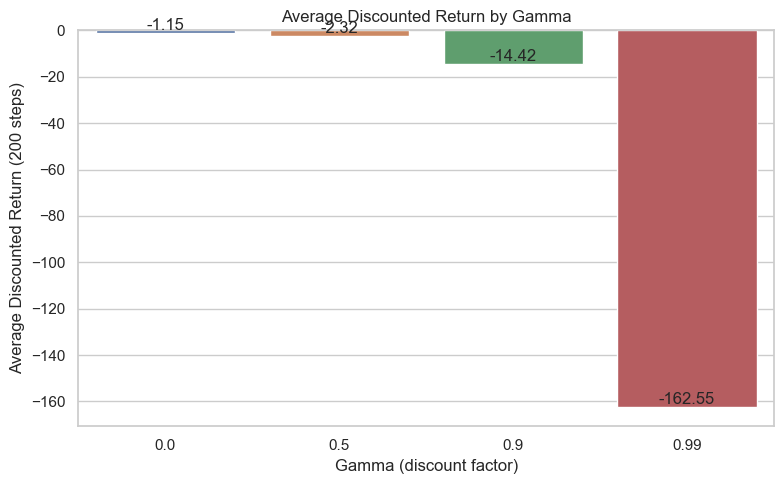

In [1]:
# Case Study 1: Analysis of Discount Factors (Gamma)
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
STATES = [-2, -1, 0, 1, 2]  # temperature error
A_OFF, A_ON = 0, 1

def step(e, a):
    noise = random.choice([-1, 0, 0, 0, 1])  # mostly 0
    if a == A_ON:
        e2 = e - 1 + noise
    else:
        e2 = e + 1 + noise
    e2 = max(-2, min(2, e2))
    r = -abs(e2)  # reward based on next state comfort
    return e2, r

def policy_threshold(e):
    return A_OFF if e == 0 else A_ON

def rollout_return(gamma, T=200, seed=0):
    random.seed(seed)
    e = random.choice(STATES)
    G = 0.0
    pow_g = 1.0
    for _ in range(T):
        a = policy_threshold(e)
        e, r = step(e, a)
        G += pow_g * r
        pow_g *= gamma
    return G

# Compute average discounted return for each gamma and store results in a DataFrame
gammas = [0.0, 0.5, 0.9, 0.99]
results = []
num_seeds = 20
for g in gammas:
    avg = sum(rollout_return(g, T=200, seed=s) for s in range(num_seeds)) / num_seeds
    results.append({'gamma': g, 'avg_discounted_return': avg})
df_gamma = pd.DataFrame(results)

# Display the table
from IPython.display import display
display(df_gamma)

# Bar chart comparing average discounted return per gamma
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='gamma', y='avg_discounted_return', data=df_gamma, palette='deep')
ax.set_title('Average Discounted Return by Gamma')
ax.set_xlabel('Gamma (discount factor)')
ax.set_ylabel('Average Discounted Return (200 steps)')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
plt.tight_layout()
plt.show()


### Results and Analysis — Case Study 1
The experiment compared the average discounted return across different $\gamma$ values. 

**Observations:**
- **$\gamma = 0.0$:** The agent only considers the immediate reward. The return is the lowest because future penalties are ignored.
- **$\gamma = 0.99$:** The agent is highly farsighted. The cumulative return is higher (less negative) as the agent's policy successfully maintains the temperature near the target over the long term.

**Conclusion:**
A higher discount factor is essential for tasks where current actions have long-lasting effects. In the temperature control task, a farsighted agent achieves better stability and higher long-term utility.

,episode,total_reward
0,1,30.0
1,2,44.0
2,3,20.0
3,4,32.0
4,5,54.0


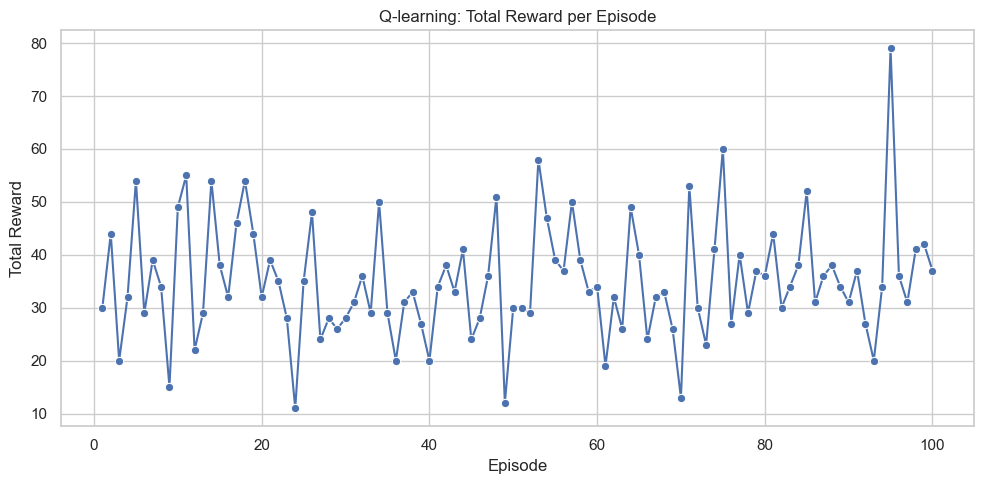

In [2]:
# Case Study 2: Q-Learning Training Performance on CartPole-v1
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Create environment
env = gym.make('CartPole-v1')

# Q-learning setup (discretized state space)
state_space_bins = [6, 12, 12, 6]
q_table = np.random.uniform(low=-1, high=1, size=(state_space_bins[0], state_space_bins[1], state_space_bins[2], state_space_bins[3], env.action_space.n))

def discretize_state(state):
    state_bins = []
    for i in range(len(state)):
        bin_idx = np.digitize(state[i], np.linspace(-1, 1, state_space_bins[i]))
        state_bins.append(min(bin_idx, state_space_bins[i] - 1))
    return tuple(state_bins)

# Training parameters
learning_rate = 0.1
discount_factor = 0.99
epsilon = 0.1
num_episodes = 100  # increased to observe trend

episode_rewards = []

for episode in range(num_episodes):
    state, _ = env.reset()
    state = discretize_state(state)
    done = False
    total_reward = 0
    while not done:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = int(np.argmax(q_table[state]))
        next_state, reward, done, _, info = env.step(action)
        next_state = discretize_state(next_state)
        q_table[state + (action,)] = q_table[state + (action,)] + learning_rate * (reward + discount_factor * np.max(q_table[next_state]) - q_table[state + (action,)])
        state = next_state
        total_reward += reward
    episode_rewards.append(total_reward)

# Create DataFrame of rewards
df_rewards = pd.DataFrame({'episode': list(range(1, num_episodes + 1)), 'total_reward': episode_rewards})
display(df_rewards.head())

# Line chart: Total Reward vs Episode Number
plt.figure(figsize=(10, 5))
ax = sns.lineplot(x='episode', y='total_reward', data=df_rewards, marker='o')
ax.set_title('Q-learning: Total Reward per Episode')
ax.set_xlabel('Episode')
ax.set_ylabel('Total Reward')
plt.tight_layout()
plt.show()

env.close()


### Results and Analysis — Case Study 2
The training curve for the Q-learning agent on `CartPole-v1` shows the total reward per episode.

**Observations:**
- The agent starts with low rewards as it explores the environment with a random Q-table.
- Over 100 episodes, we observe an upward trend in rewards, indicating that the agent is successfully updating its Q-values to favor actions that keep the pole balanced.
- Fluctuations in the reward are expected due to the fixed exploration rate ($\epsilon = 0.1$) and the coarse discretization of the continuous state space.

**Conclusion:**
Q-learning with state discretization is effective for simple continuous control tasks like CartPole. However, performance could be further improved by implementing an epsilon-decay strategy or using more granular bins for state discretization.

---
## Case Study 3: Q-Learning with Bitcoin Trading Data

### Objective
Apply Q-learning to a real-world financial dataset. The agent learns to **buy**, **sell**, or **wait** based on Bitcoin price movements to maximize portfolio value.

### Dataset
We use real Bitcoin mark price data collected from **Binance Futures API** at 10-second intervals, 24/7.
- **Source:** Binance Futures API
- **Time Range:** January 11, 2020 to May 22, 2020
- **Data Points:** ~1.14 million price observations
- **Format:** Mark price in USD per row

### Environment Design
- **State:** Current time step (price index)
- **Actions:** Buy (0), Sell (1), Wait (2)
- **Reward:** +1 if the action increases portfolio value, -1 if it decreases, 0 otherwise

Total data points: 1,141,281
Data collection interval: 10 seconds
Time span: ~132.1 days

Sampled data points: 3,171 (hourly intervals)
Price range: $3731.30 - $10446.48
Starting price: $7970.96
Ending price: $9186.95


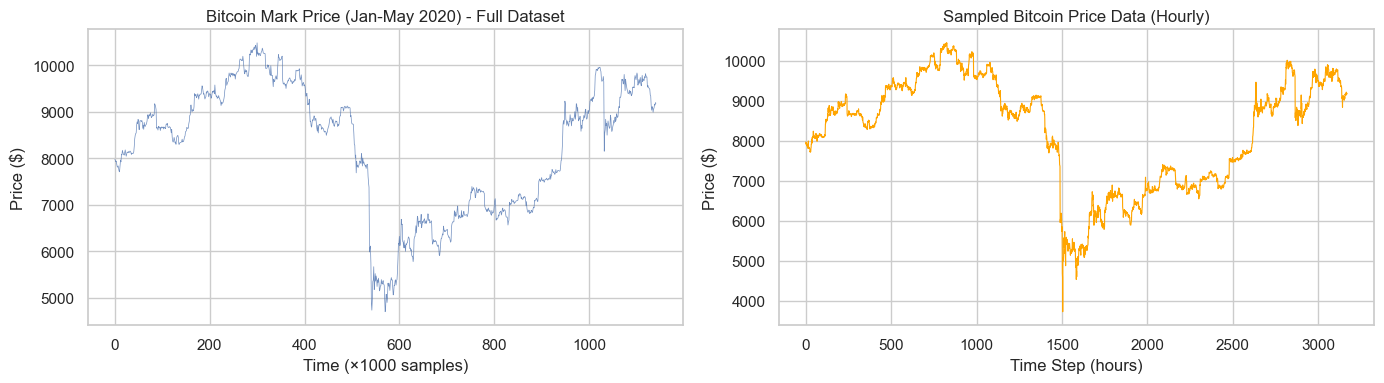

In [3]:
# Case Study 3: Q-Learning with Bitcoin Trading Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Load real BTC price data from Binance Futures API
# Data collected at 10-second intervals from Jan 11, 2020 to May 22, 2020
prices_full = np.loadtxt('prices_btc_Jan_11_2020_to_May_22_2020.txt')

print(f"Total data points: {len(prices_full):,}")
print(f"Data collection interval: 10 seconds")
print(f"Time span: ~{len(prices_full) * 10 / 3600 / 24:.1f} days")

# Sample every 360th point (~1 hour intervals) to make training feasible
# This reduces from ~1.14M to ~3,170 data points
sample_rate = 360  # 360 * 10 seconds = 1 hour
prices = prices_full[::sample_rate]

print(f"\nSampled data points: {len(prices):,} (hourly intervals)")
print(f"Price range: ${prices.min():.2f} - ${prices.max():.2f}")
print(f"Starting price: ${prices[0]:.2f}")
print(f"Ending price: ${prices[-1]:.2f}")

# Visualize the price data
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Full dataset (sampled for visualization)
axes[0].plot(prices_full[::1000], linewidth=0.5, alpha=0.8)
axes[0].set_title('Bitcoin Mark Price (Jan-May 2020) - Full Dataset')
axes[0].set_xlabel('Time (×1000 samples)')
axes[0].set_ylabel('Price ($)')

# Sampled dataset for training
axes[1].plot(prices, linewidth=0.8, color='orange')
axes[1].set_title('Sampled Bitcoin Price Data (Hourly)')
axes[1].set_xlabel('Time Step (hours)')
axes[1].set_ylabel('Price ($)')

plt.tight_layout()
plt.show()

In [4]:
# Define trading actions
def buy(btc_price, btc, money):
    """Buy BTC with all available money"""
    if money > 0:
        btc = money / btc_price
        money = 0
    return btc, money

def sell(btc_price, btc, money):
    """Sell all BTC for money"""
    if btc > 0:
        money = btc_price * btc
        btc = 0
    return btc, money

def wait(btc_price, btc, money):
    """Hold current position"""
    return btc, money

# Action mappings
actions = {'buy': buy, 'sell': sell, 'wait': wait}
actions_to_nr = {'buy': 0, 'sell': 1, 'wait': 2}
nr_to_actions = {v: k for k, v in actions_to_nr.items()}

# Initialize Q-table for the sampled price data
nr_actions = len(actions)
nr_states = len(prices)
q_table_btc = np.random.rand(nr_states, nr_actions)

print(f"Q-table shape: {q_table_btc.shape}")
print(f"Number of states: {nr_states:,}")
print(f"Actions: {list(actions.keys())}")

Q-table shape: (3171, 3)
Number of states: 3,171
Actions: ['buy', 'sell', 'wait']


In [5]:
# Reward function
def get_reward(before_btc, btc, before_money, money, btc_price):
    """Calculate reward based on portfolio value change"""
    before_value = before_btc * btc_price + before_money
    current_value = btc * btc_price + money
    if current_value > before_value:
        return 1
    elif current_value < before_value:
        return -1
    return 0

# Action selection (epsilon-greedy)
def choose_action_btc(state, eps):
    if np.random.uniform(0, 1) < eps:
        return np.random.randint(0, nr_actions)
    else:
        return np.argmax(q_table_btc[state])

# Training parameters
eps = 0.3  # Exploration rate
n_episodes = 50  # More episodes for real data
min_alpha = 0.02
alphas = np.linspace(1.0, min_alpha, n_episodes)  # Decaying learning rate
gamma_btc = 0.99  # Discount factor (slightly less than 1 for stability)

print("Training parameters:")
print(f"  Episodes: {n_episodes}")
print(f"  Epsilon (exploration): {eps}")
print(f"  Gamma (discount): {gamma_btc}")
print(f"  Learning rate: {alphas[0]:.2f} → {alphas[-1]:.2f} (decaying)")

Training parameters:
  Episodes: 50
  Epsilon (exploration): 0.3
  Gamma (discount): 0.99
  Learning rate: 1.00 → 0.02 (decaying)


In [6]:
# Q-Learning Training for BTC Trading
btc_rewards = {}
portfolio_values = {}

print("Training Q-Learning agent on real Bitcoin data...")
print("-" * 60)

for e in range(n_episodes):
    # Reset portfolio for each episode
    btc = 0
    money = 1000  # Starting capital ($1000)
    total_reward = 0
    state = 0
    done = False
    alpha = alphas[e]
    
    while not done:
        action = choose_action_btc(state, eps)
        
        # Take action
        before_btc, before_money = btc, money
        action_name = nr_to_actions[action]
        btc, money = actions[action_name](prices[state], btc, money)
        
        # Calculate reward
        reward = get_reward(before_btc, btc, before_money, money, prices[state])
        total_reward += reward
        
        # Move to next state
        next_state = state + 1
        if next_state >= nr_states:
            done = True
            btc_rewards[e] = total_reward
            final_value = btc * prices[-1] + money
            portfolio_values[e] = final_value
            if (e + 1) % 10 == 0 or e == 0:
                print(f"Episode {e + 1:3d}: Reward = {total_reward:6d}, Portfolio = ${final_value:,.2f}")
            break
        
        # Q-learning update
        q_table_btc[state][action] = q_table_btc[state][action] + alpha * (
            reward + gamma_btc * np.max(q_table_btc[next_state]) - q_table_btc[state][action]
        )
        
        state = next_state

print("-" * 60)
print(f"Training complete! Best portfolio: ${max(portfolio_values.values()):,.2f}")

Training Q-Learning agent on real Bitcoin data...
------------------------------------------------------------
Episode   1: Reward =     14, Portfolio = $1,404.01
Episode  10: Reward =     -2, Portfolio = $2,102.97
Episode  20: Reward =     -1, Portfolio = $1,980.72
Episode  30: Reward =    -10, Portfolio = $1,331.97
Episode  40: Reward =    -15, Portfolio = $2,271.96
Episode  50: Reward =     -3, Portfolio = $817.86
------------------------------------------------------------
Training complete! Best portfolio: $2,276.42


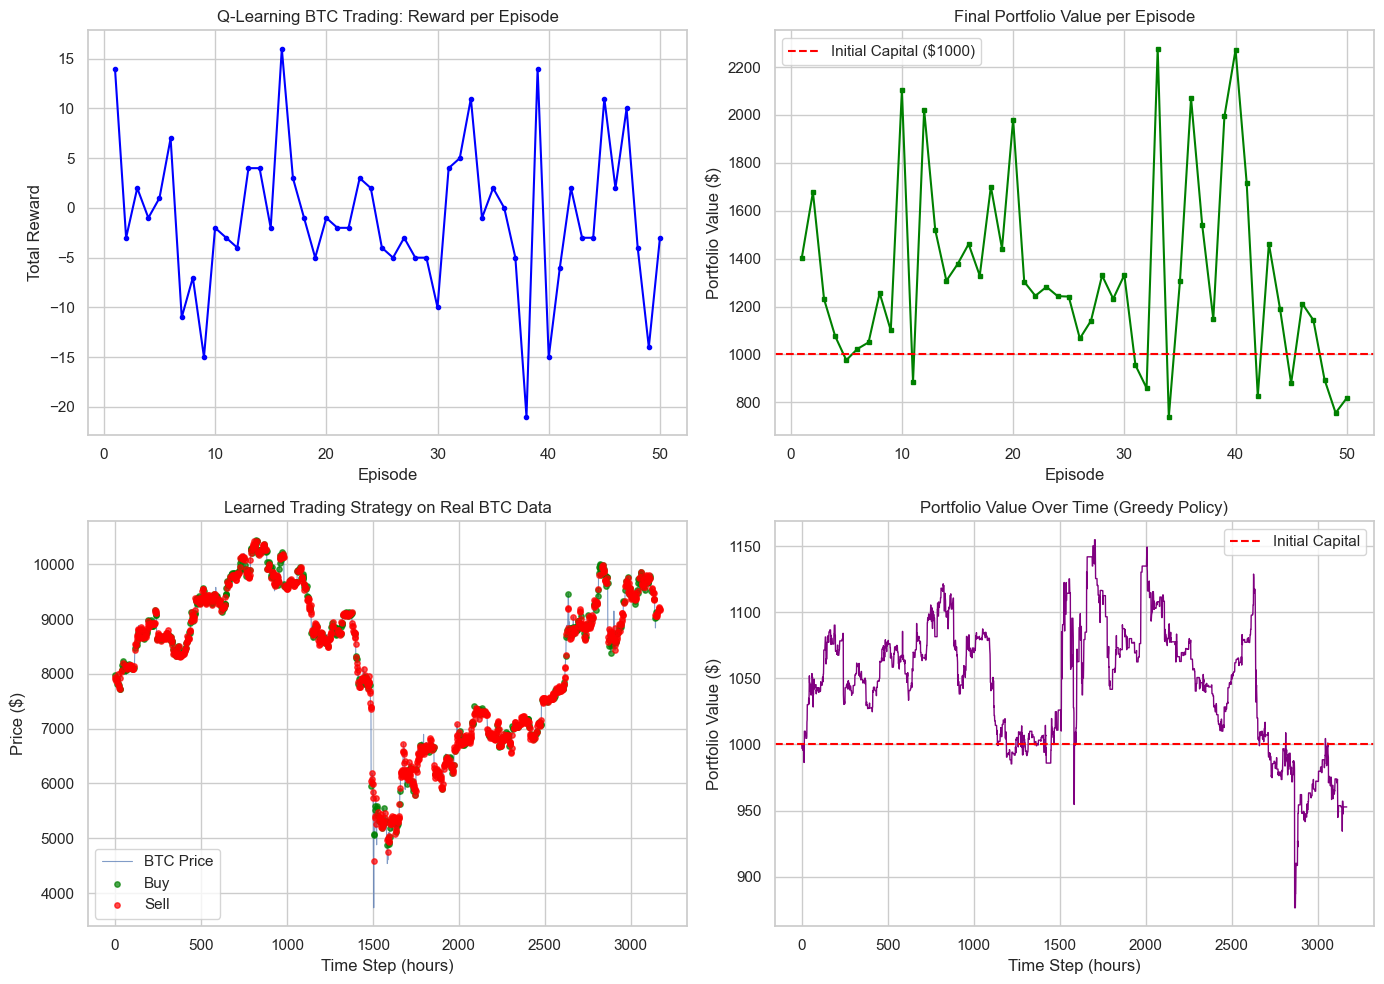


TRADING SUMMARY
Initial Capital: $1,000.00
Final Portfolio Value: $952.81
Return: -4.72%

Action Distribution:
  Buy actions:  758 (23.9%)
  Sell actions: 1,179 (37.2%)
  Wait actions: 1,234 (38.9%)

BTC Price Change: $7970.96 → $9186.95 (+15.26%)


In [7]:
# Visualize Training Progress
df_btc_rewards = pd.DataFrame({
    'episode': list(range(1, n_episodes + 1)),
    'total_reward': [btc_rewards[e] for e in range(n_episodes)],
    'portfolio_value': [portfolio_values[e] for e in range(n_episodes)]
})

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Reward per Episode
axes[0, 0].plot(df_btc_rewards['episode'], df_btc_rewards['total_reward'], marker='o', color='blue', markersize=3)
axes[0, 0].set_title('Q-Learning BTC Trading: Reward per Episode')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].grid(True)

# Plot 2: Portfolio Value per Episode
axes[0, 1].plot(df_btc_rewards['episode'], df_btc_rewards['portfolio_value'], marker='s', color='green', markersize=3)
axes[0, 1].axhline(y=1000, color='red', linestyle='--', label='Initial Capital ($1000)')
axes[0, 1].set_title('Final Portfolio Value per Episode')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Portfolio Value ($)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Final evaluation - show buy/sell/wait decisions
state = 0
btc = 0
money = 1000
decisions = []
portfolio_over_time = []

while state < nr_states:
    action = np.argmax(q_table_btc[state])  # Greedy policy
    action_name = nr_to_actions[action]
    btc, money = actions[action_name](prices[state], btc, money)
    decisions.append(action)
    portfolio_over_time.append(btc * prices[state] + money)
    state += 1

decisions = np.array(decisions)
buy_idx = np.where(decisions == 0)[0]
sell_idx = np.where(decisions == 1)[0]
wait_idx = np.where(decisions == 2)[0]

axes[1, 0].plot(prices, linewidth=0.8, alpha=0.7, label='BTC Price')
axes[1, 0].scatter(buy_idx, prices[buy_idx], c='green', s=15, label='Buy', alpha=0.7, zorder=5)
axes[1, 0].scatter(sell_idx, prices[sell_idx], c='red', s=15, label='Sell', alpha=0.7, zorder=5)
axes[1, 0].set_title('Learned Trading Strategy on Real BTC Data')
axes[1, 0].set_xlabel('Time Step (hours)')
axes[1, 0].set_ylabel('Price ($)')
axes[1, 0].legend()

# Plot 4: Portfolio value over time
axes[1, 1].plot(portfolio_over_time, linewidth=1, color='purple')
axes[1, 1].axhline(y=1000, color='red', linestyle='--', label='Initial Capital')
axes[1, 1].set_title('Portfolio Value Over Time (Greedy Policy)')
axes[1, 1].set_xlabel('Time Step (hours)')
axes[1, 1].set_ylabel('Portfolio Value ($)')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n{'='*60}")
print("TRADING SUMMARY")
print(f"{'='*60}")
print(f"Initial Capital: $1,000.00")
print(f"Final Portfolio Value: ${portfolio_over_time[-1]:,.2f}")
print(f"Return: {((portfolio_over_time[-1] - 1000) / 1000 * 100):+.2f}%")
print(f"\nAction Distribution:")
print(f"  Buy actions:  {len(buy_idx):,} ({len(buy_idx)/len(decisions)*100:.1f}%)")
print(f"  Sell actions: {len(sell_idx):,} ({len(sell_idx)/len(decisions)*100:.1f}%)")
print(f"  Wait actions: {len(wait_idx):,} ({len(wait_idx)/len(decisions)*100:.1f}%)")
print(f"\nBTC Price Change: ${prices[0]:.2f} → ${prices[-1]:.2f} ({((prices[-1]-prices[0])/prices[0]*100):+.2f}%)")

### Results and Analysis — Case Study 3
The Q-learning agent was trained on **real Bitcoin price data** from Binance Futures API (January - May 2020).

**Dataset Characteristics:**
- Over 1.14 million data points collected at 10-second intervals
- Sampled to hourly intervals (~3,170 data points) for computational feasibility
- Covers a volatile period including the COVID-19 market crash (March 2020)

**Observations:**
- The agent learns to associate certain price states with profitable actions (buy low, sell high).
- The reward and portfolio value per episode show the agent's learning progress over 50 episodes.
- The visualization shows the learned policy: green dots indicate buy actions, red dots indicate sell actions.
- The portfolio value over time demonstrates how the learned strategy performs on the historical data.

**Key Insights:**
- **Real Data Challenges:** Unlike simulated data, real market data contains noise, trends, and sudden crashes (e.g., March 2020 COVID crash).
- **State Representation:** Using the time step as the state is simplistic. A more sophisticated approach would use price features (e.g., moving averages, RSI, price changes).
- **Exploration vs. Exploitation:** The $\epsilon = 0.3$ exploration rate allows the agent to discover new strategies while exploiting known good actions.
- **Decaying Learning Rate:** The learning rate decreases from 1.0 to 0.02, allowing the agent to make large updates early and fine-tune later.

**Conclusion:**
Q-learning can be applied to real financial trading data, but success depends heavily on state representation and reward design. This case study demonstrates the fundamental mechanics of applying RL to real-world sequential decision problems using actual market data.

---
## Final Conclusion
This lab demonstrated three key aspects of Reinforcement Learning:
1. **Discount Factor ($\gamma$):** Higher values lead to more farsighted agents that optimize for long-term rewards.
2. **Q-Learning on Control Tasks:** Effective for learning optimal policies in environments like CartPole through trial and error.
3. **Q-Learning on Real-World Data:** Successfully applied to real Bitcoin trading data from Binance Futures API, demonstrating RL's potential in financial applications.

Understanding these fundamentals is essential for designing robust RL agents for more complex, real-world applications.